In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

from cloudmodel.unified.units import (
    Time,
)

from exp_alibaba import get_alibaba_workloads

FIG_DIR = Path("figs")

# Traces

In [2]:
window_size_to_resample_period = {
    Time("1 sec"): "1s",
    Time("1 min"): "1T",
    Time("5 min"): "5T",
    Time("15 min"): "15T",
    Time("1 hour"): "60T",
}

traces = {}
for window_size in [Time("1 sec"), Time("5 min"), Time("15 min"), Time("1 hour")]:
    wl_s, wl_l = get_alibaba_workloads(window_size_to_resample_period[window_size])
    traces[window_size] = wl_s, wl_l

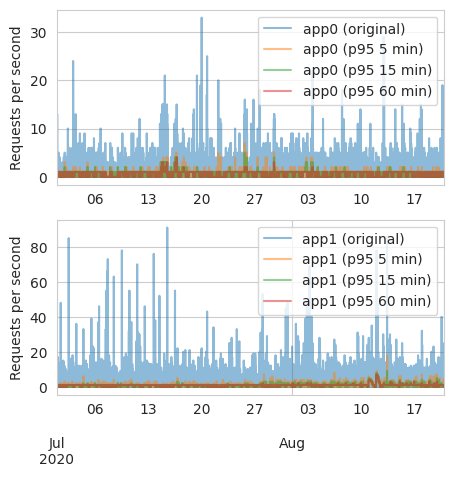

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
for window_size in traces:
    wl_s, wl_l = traces[window_size]

    for wl in [wl_s, wl_l]:
        timestamps = pd.date_range(
            start="2020-07-01 0:00:00",
            periods=len(wl),
            freq=window_size_to_resample_period[window_size],
        )

        rps = pd.Series(wl, index=timestamps) / window_size.to("s").magnitude
        app_name = "app0" if wl == wl_s else "app1"
        if window_size == Time("1 sec"):
            label = f"{app_name} (original)"
        else:
            label_size = f"{int(window_size.to('min').magnitude)}"
            label = f"{app_name} (p95 {label_size} min)"

        if wl == wl_s:
            ax_ = ax[0]
            rps.plot(
                ax=ax_,
                label=label,
                alpha=0.5,
                drawstyle="steps-post",
                xticks=[],
                xlabel="",
            )
        else:
            ax_ = ax[1]
            rps.plot(ax=ax_, label=label, alpha=0.5, drawstyle="steps-post")
        # rps.loc[:"2020-07-01 2:00:00"].plot(ax=ax_, label=label, alpha=0.5, drawstyle="steps-post")

        # Add Y axis label only to the left plot
        ax_.set_ylabel("Requests per second")

        # Remove the X axis label from the first plot
        if wl == wl_s:
            ax_.set_xlabel("")

    ax[0].legend(loc="upper right")
    ax[1].legend(loc="upper right")

fig.savefig(FIG_DIR / f"alibaba_traces.pdf", bbox_inches="tight")

# Results

In [5]:
import pickle
import pint

from exp_alibaba import SummaryStats
from cloudmodel.unified.units import ureg
from pint import set_application_registry

set_application_registry(ureg)

# SummaryStats is defined like this:
# @dataclass(frozen=True)
# class SummaryStats:
#     workload: tuple[float, float]
#     cost: pint.Quantity
#     num_vms: int
#     num_containers: int
#     sol: Solution


with open("summary_sol_gap_0_max_sec_120_limit_20_alibaba_gpu_p95.p", "rb") as f:
    summary: dict[pint.Quantity, list[dict[str, SummaryStats]]] = pickle.load(f)


In [ ]:

# The summary has this type: dict[pint.Quantity, list[dict[str, SummaryStats]]]
# with the str being the allocator name and each element in the list representing a time
# slot for that window size. Convert to a DataFrame with the following columns:
# - window_size
# - allocator
# - time
# - workload
# - cost
# - num_vms
# - num_containers
summary_df = pd.DataFrame(
    [
        {
            "window_size": int(window_size.to("min").magnitude),
            "allocator": allocator,
            "time_slot": time_slot,
            "time_sec": time_slot * window_size.to("s").magnitude,
            "workload": summary[window_size][time_slot][allocator].workload,
            "cost_usd": summary[window_size][time_slot][allocator].cost.to("usd").magnitude,
            "num_vms": summary[window_size][time_slot][allocator].num_vms,
            "num_containers": summary[window_size][time_slot][allocator].num_containers,
        }
        for window_size in summary
        for time_slot in range(len(summary[window_size]))
        for allocator in summary[window_size][time_slot]
    ]
)

In [ ]:
summary_df.head()

,window_size,allocator,time_slot,time_sec,workload,cost_usd,num_vms,num_containers
0,5,conlloovia,0,0,"(300.0, 300.0)",0.014167,2,2.0
1,5,FFC,0,0,"(300.0, 300.0)",0.014167,1,4.0
2,5,FFP,0,0,"(300.0, 300.0)",0.014167,2,4.0
3,5,conlloovia,1,300,"(300.0, 300.0)",0.014167,2,2.0
4,5,FFC,1,300,"(300.0, 300.0)",0.014167,1,4.0


In [ ]:
# Agrregate the data by allocator and window size
summary_df_agg = (
    summary_df.groupby(["allocator", "window_size"])
    .agg(
        {
            "cost_usd": ["sum", "mean", "std"],
            "num_vms": ["sum", "mean", "std"],
            "num_containers": ["sum", "mean", "std"],
        }
    )
    .reset_index()
)
summary_df_agg


allocator window_size    cost_usd                     num_vms            \
                                  sum      mean       std     sum      mean   
0         FFC           5  173.137917  0.011788  0.008618   11999  0.816925   
1         FFC          15  176.481250  0.036046  0.024202    4036  0.824346   
2         FFC          60  187.255000  0.152986  0.083491    1081  0.883170   
3         FFP           5  168.335417  0.011461  0.008067   23765  1.617987   
4         FFP          15  172.146250  0.035161  0.022609    8101  1.654616   
5         FFP          60  184.280000  0.150556  0.078532    2168  1.771242   
6  conlloovia           5  141.624167  0.009642  0.007464   18658  1.270289   
7  conlloovia          15  143.437500  0.029297  0.021143    6466  1.320670   
8  conlloovia          60  154.020000  0.125833  0.076920    1752  1.431373   

            num_containers                      
        std            sum      mean       std  
0  0.441954        43464.0  2.959150  2.180297  
1  0.425667        14828.0  3.028595  2.030513  
2  0.362030         3981.0  3.252451  1.794648  
3  1.138933        43464.0  2.959150  2.180297  
4  1.063937        14828.0  3.028595  2.030513  
5  0.923903         3981.0  3.252451  1.794648  
6  0.850384        21103.0  1.436751  1.160599  
7  0.879287         8904.0  1.818627  1.382138  
8  0.813940         2427.0  1.982843  1.294254

In [ ]:
# Create a new dataframe with only the mean cost_usd and on level instead of the multi-index
cost_df = (summary_df_agg[["allocator", "window_size", "cost_usd"]]
    .drop(["mean", "std"], level=1, axis=1)
    .droplevel(1, axis=1)
)
cost_df

,allocator,window_size,cost_usd
0,FFC,5,173.137917
1,FFC,15,176.481250
2,FFC,60,187.255000
3,FFP,5,168.335417
4,FFP,15,172.146250
5,FFP,60,184.280000
6,conlloovia,5,141.624167
7,conlloovia,15,143.437500
8,conlloovia,60,154.020000


In [ ]:
# Add a column with the difference in percentage between the cost of the allocator
# and the cost of conlloovia with a 5 minute window size
base_cost = cost_df.query("allocator == 'conlloovia' and window_size == 5")["cost_usd"].values[0]
cost_df["cost_diff"] = (cost_df["cost_usd"] - base_cost) / base_cost * 100

# Put the window size in seconds
cost_df["window_size_sec"] = cost_df["window_size"] * 60

cost_df

,allocator,window_size,cost_usd,cost_diff,window_size_sec
0,FFC,5,173.137917,22.251676,300
1,FFC,15,176.481250,24.612384,900
2,FFC,60,187.255000,32.219666,3600
3,FFP,5,168.335417,18.860658,300
4,FFP,15,172.146250,21.551465,900
5,FFP,60,184.280000,30.119036,3600
6,conlloovia,5,141.624167,0.000000,300
7,conlloovia,15,143.437500,1.280384,900
8,conlloovia,60,154.020000,8.752626,3600


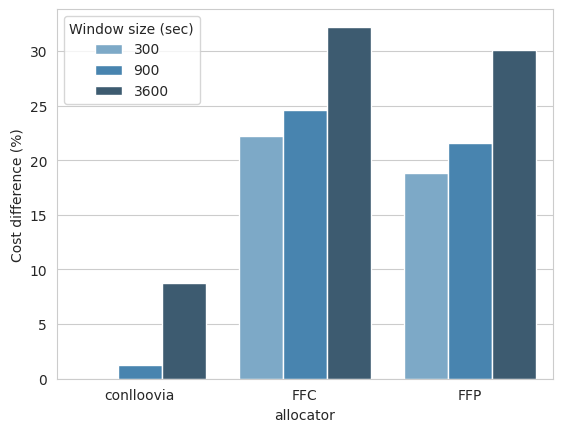

In [ ]:
# Plot cost_diff
g = sns.barplot(
    data=cost_df,
    x="allocator",
    y="cost_diff",
    hue="window_size_sec",
    palette="Blues_d",
    order=["conlloovia", "FFC", "FFP"]
)

g.set_ylabel("Cost difference (%)")
sns.move_legend(g, "best", title='Window size (sec)')

# Save figure
plt.savefig(FIG_DIR / f"alibaba_cost_diff.pdf", bbox_inches="tight")